## **1. Data Import and Basic Overview**

In [ ]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loading the Data
data = pd.read_csv('/content/drive/My Drive/UM PROJECTS/CloudWatch_Traffic_Web_Attack.csv')
print('shape is = {}'.format(data.shape))
# Display the first few rows of the DataFrame to understand its structure
print(data.head())
data.info()

shape is = (282, 16)
   bytes_in  bytes_out         creation_time              end_time  \
0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_name  \
0  10.138.69.97  Sus

## **2. Data Preprocessing**

In [ ]:
# Remove duplicate rows
cyber = data.drop_duplicates()
# Convert time-related columns to datetime format
cyber['creation_time'] = pd.to_datetime(cyber['creation_time'])
cyber['end_time'] = pd.to_datetime(cyber['end_time'])
cyber['time'] = pd.to_datetime(cyber['time'])
# Standardize text data (example: convert to lower case)
cyber['src_ip_country_code'] = cyber['src_ip_country_code'].str.upper()  # Ensuring country codes are all upper case
# Display changes and current state of the DataFrame
print("Unique Datasets Information:")
cyber.info()


Unique Datasets Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object            

Initial Observations:
The dataset has 282 rows and 16 columns.

No missing values.

Date-time fields (creation_time, end_time, time) need to be converted to datetime format.

The dataset includes network traffic details (bytes, ports, IPs, protocols, response codes, etc.).

rule_names and observation_name indicate the type of attack detected.

detection_types specifies the method used for detection.

In [ ]:
print("Top 5 Unique Datasets Information:")
cyber.head()

Top 5 Unique Datasets Information:


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule


## **3. Exploratory Data Analysis (EDA)**

**Descriptive Analysis**

📊 1. Top 10 Source Countries

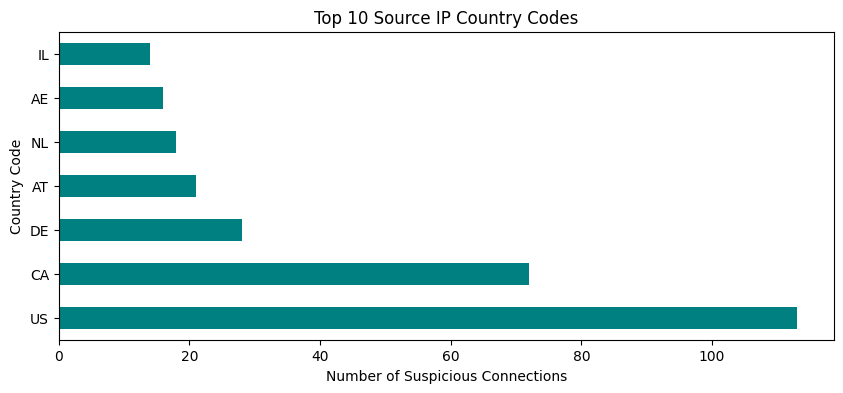

In [ ]:
top_countries = cyber['src_ip_country_code'].value_counts().head(10)
top_countries.plot(kind='barh', figsize=(10, 4), title='Top 10 Source IP Country Codes', color='teal')
plt.xlabel("Number of Suspicious Connections")
plt.ylabel("Country Code")
plt.show()

📈 2. Suspicious Traffic by Hour

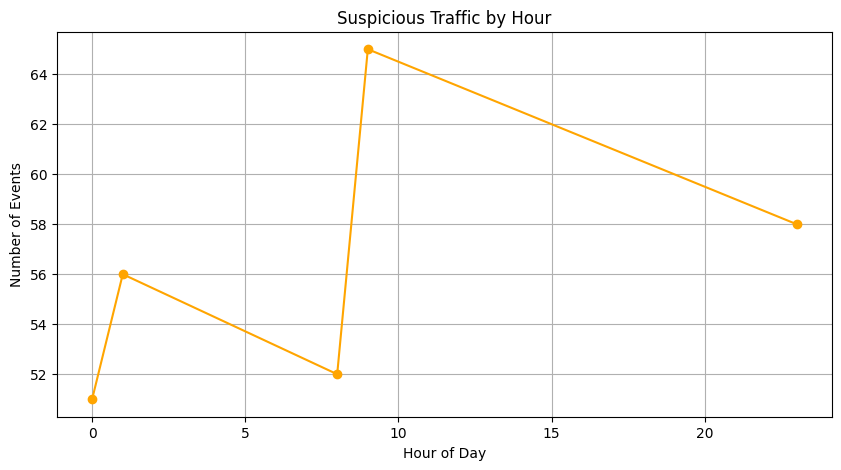

In [ ]:
cyber['hour'] = cyber['time'].dt.hour
cyber['hour'].value_counts().sort_index().plot(kind='line', marker='o', figsize=(10, 5), title='Suspicious Traffic by Hour', color='orange')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Events")
plt.grid(True)
plt.show()


🧪 3. HTTP Response Code Distribution

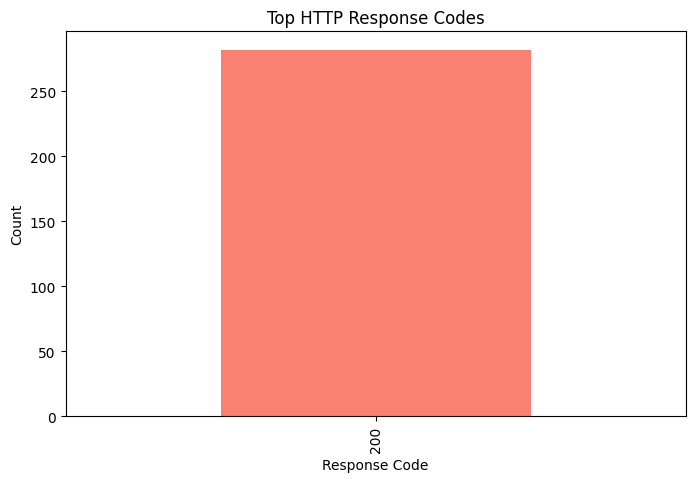

In [ ]:
cyber['response.code'].value_counts().head(10).plot(kind='bar', color='salmon', figsize=(8, 5), title='Top HTTP Response Codes')
plt.xlabel("Response Code")
plt.ylabel("Count")
plt.show()


🔌 4. Destination Ports (Top 10)

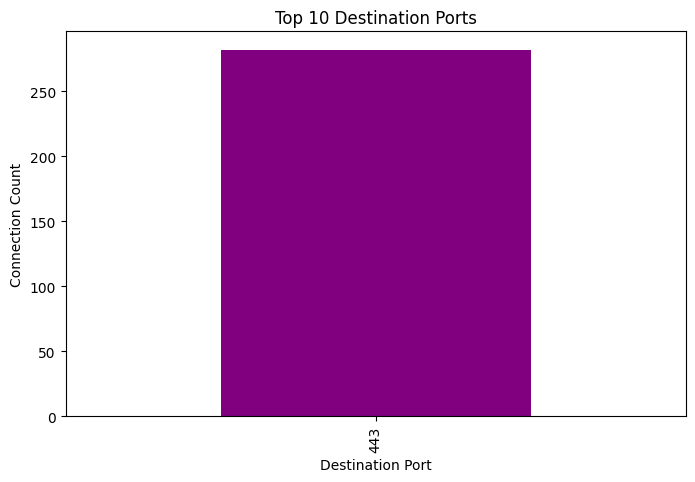

In [ ]:
cyber['dst_port'].value_counts().head(10).plot(kind='bar', color='purple', figsize=(8, 5), title='Top 10 Destination Ports')
plt.xlabel("Destination Port")
plt.ylabel("Connection Count")
plt.show()


🔁 5. Traffic Volume Distribution



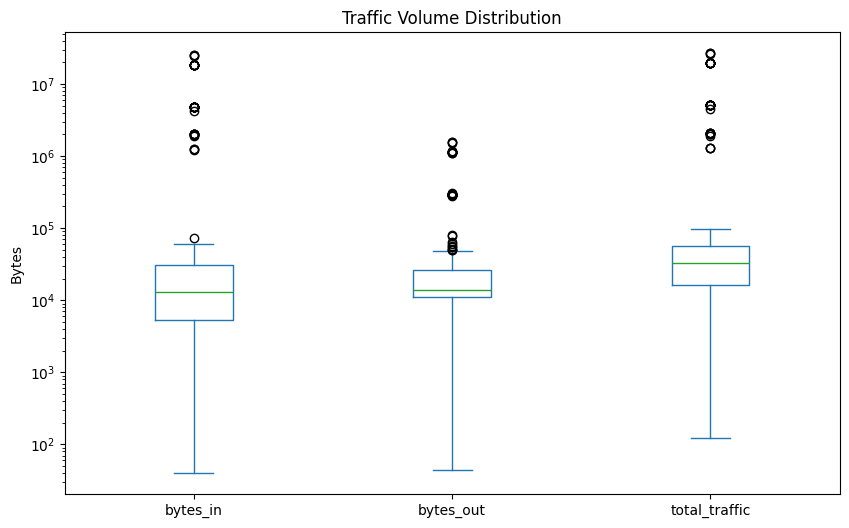

In [ ]:
cyber['total_traffic'] = cyber['bytes_in'] + cyber['bytes_out']
cyber[['bytes_in', 'bytes_out', 'total_traffic']].plot(kind='box', figsize=(10, 6), title='Traffic Volume Distribution')
plt.ylabel("Bytes")
plt.yscale('log')  # Optional: to handle outliers better
plt.show()


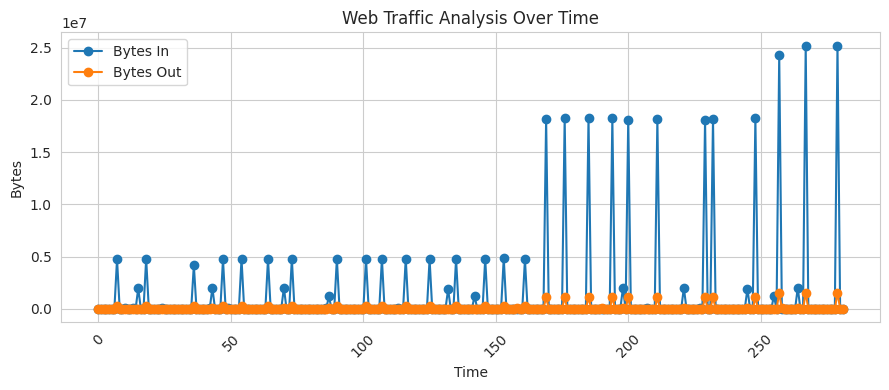

In [ ]:
# Plotting
plt.figure(figsize=(9, 4))
plt.plot(data.index, data['bytes_in'], label='Bytes In',
marker='o')
plt.plot(data.index, data['bytes_out'], label='Bytes Out',
marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Show the plot
plt.show()

**Correlation Analysis**

1. Correlation Matrix (Heatmap)

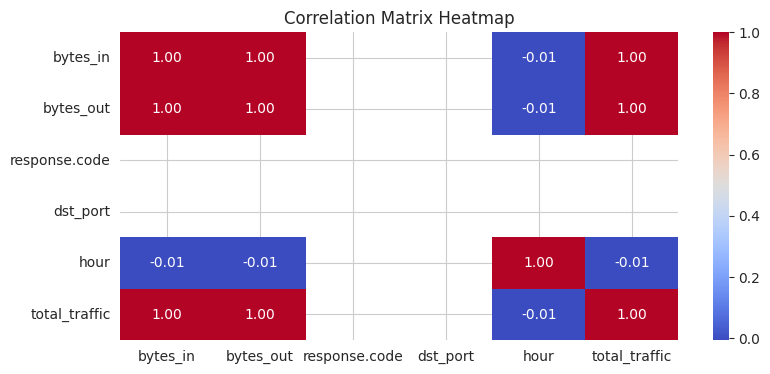

In [ ]:
# Heatmap for the correlation matrix
# Assuming 'cyber' is your DataFrame with numeric columns
numeric_cols = cyber.select_dtypes(include=np.number).columns
correlation_matrix_numeric = cyber[numeric_cols].corr()
plt.figure(figsize=(9, 4))
sns.heatmap(correlation_matrix_numeric, annot=True, fmt=".2f",
cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


✅ Insights to Look For:

total_traffic should be highly correlated with both bytes_in and bytes_out.

Weak correlations with duration_sec may indicate behavior-based anomalies.

2. Pair Plot (Scatterplot Matrix)

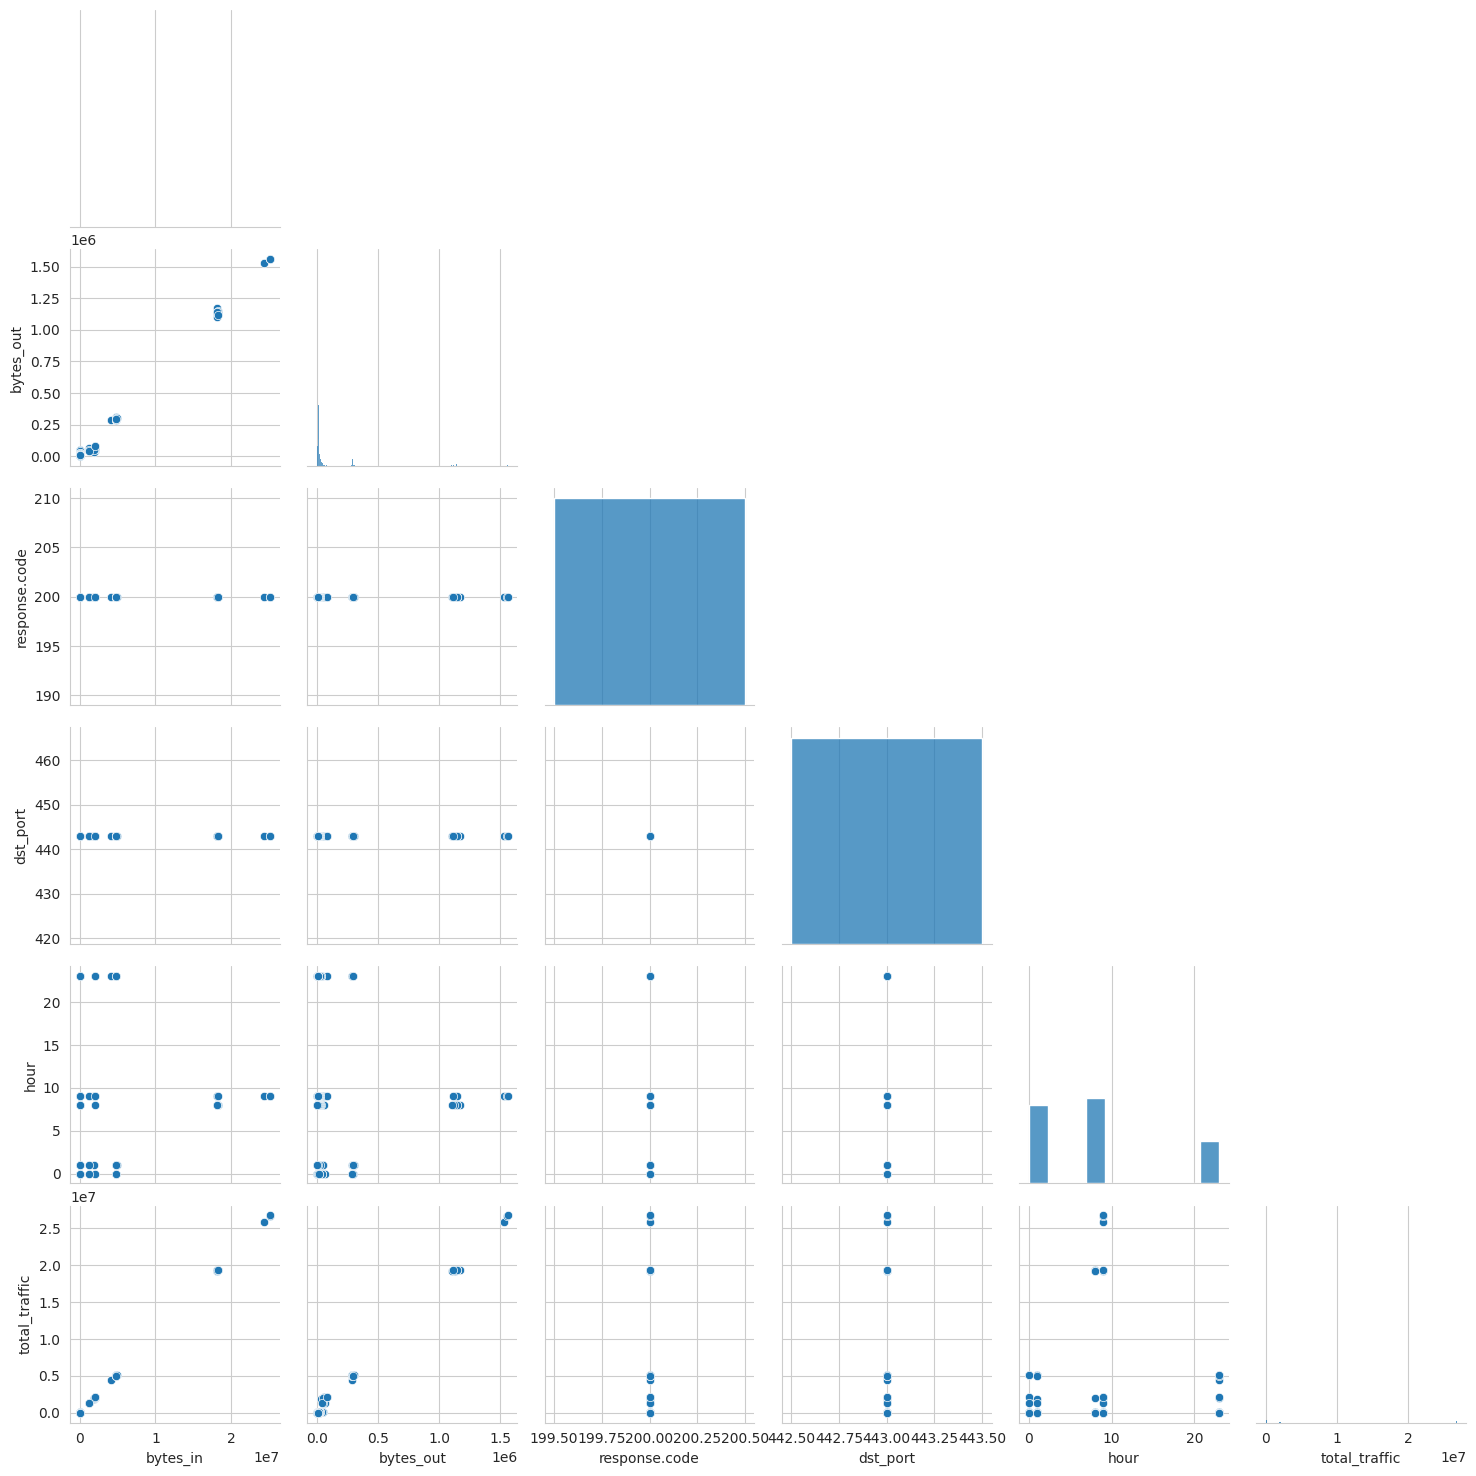

<Figure size 800x300 with 0 Axes>

In [ ]:
sns.pairplot(cyber[numeric_cols], corner=True)
plt.figure(figsize=(8, 3))
plt.suptitle("Pairwise Relationships Between Numeric Features", y=1)
plt.show()


✅ What It Shows:

Clusters or linear trends between variables.

Helps detect non-linear or unexpected patterns.

3. Scatter Plot: duration_sec vs. total_traffic

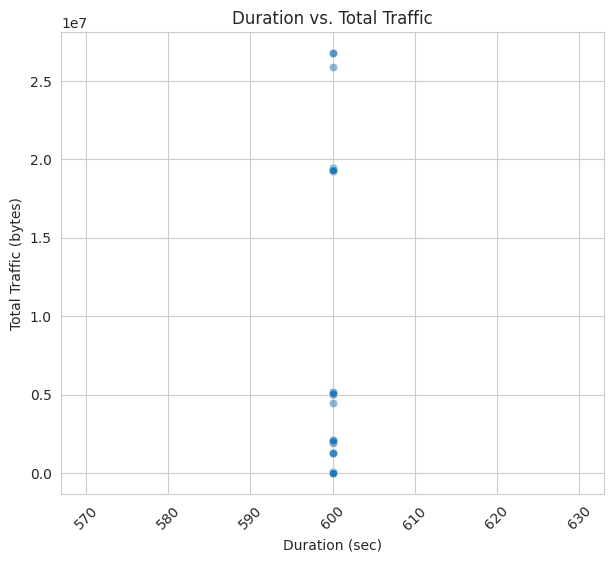

In [ ]:
cyber['total_traffic'] = cyber['bytes_in'] + cyber['bytes_out']
cyber['duration_seconds'] = (cyber['end_time'] - cyber['creation_time']).dt.total_seconds()
plt.figure(figsize=(7,6))
sns.scatterplot(x='duration_seconds', y='total_traffic', data=cyber, alpha=0.5)
plt.title('Duration vs. Total Traffic')
plt.xlabel('Duration (sec)')
plt.ylabel('Total Traffic (bytes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


✅ Use This To Spot:

Sessions with very high traffic but low duration → possible data exfiltration.

Long-duration low-traffic sessions → potential backdoors or slow scans.

4. Histogram Overlay: bytes_in vs. bytes_out

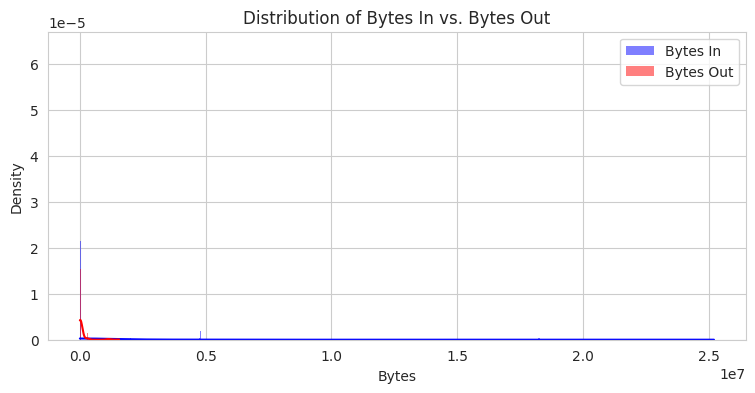

In [ ]:
plt.figure(figsize=(9,4))
sns.histplot(cyber['bytes_in'], color='blue', label='Bytes In', kde=True, stat="density", linewidth=0)
sns.histplot(cyber['bytes_out'], color='red', label='Bytes Out', kde=True, stat="density", linewidth=0)
plt.title('Distribution of Bytes In vs. Bytes Out')
plt.xlabel('Bytes')
plt.legend()
plt.show()


✅ Helps Visualize:

Whether incoming or outgoing data dominates.

If attack traffic tends to download/upload more data.

**Distribution Analysis**

1. Histogram with KDE Curve

Shows how a feature is distributed and whether it's skewed (e.g., long tails).

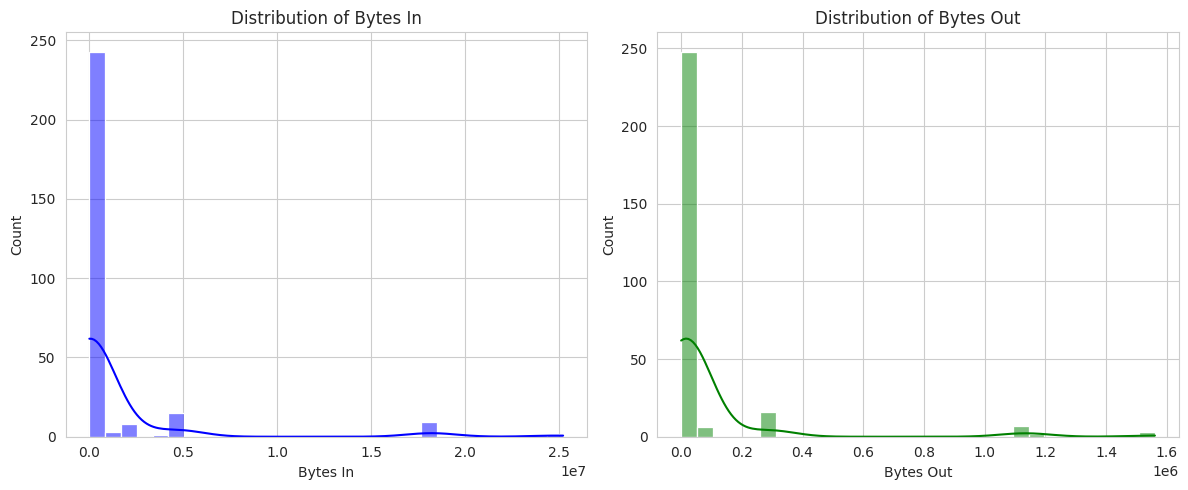

In [ ]:
# Set visualization style
sns.set_style("whitegrid")

# Plot distribution of bytes_in and bytes_out
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(cyber['bytes_in'], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Bytes In")
axes[0].set_xlabel("Bytes In")

sns.histplot(cyber['bytes_out'], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Bytes Out")
axes[1].set_xlabel("Bytes Out")

plt.tight_layout()
plt.show()


🧠 Insights:

Long tails = extreme sessions (e.g., DDoS or data exfiltration).

Clusters or gaps might indicate distinct traffic behaviors (benign vs. malicious).



2. Distribution by Hour of Day (Traffic Pattern)

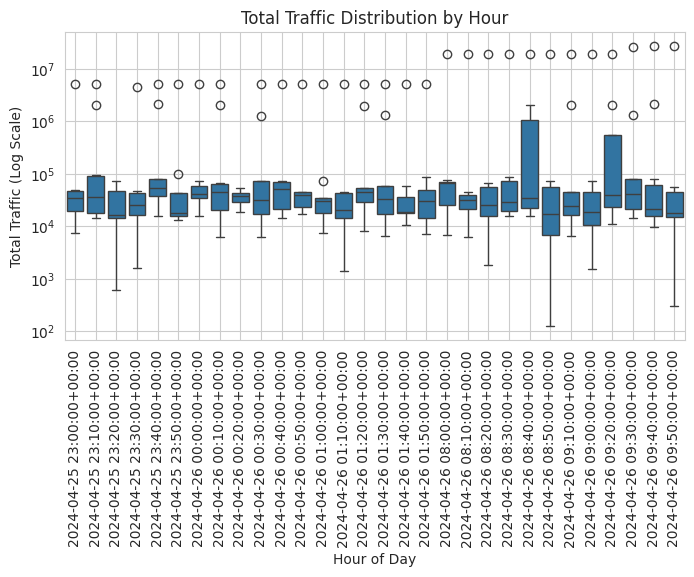

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='time', y='total_traffic', data=cyber)
plt.yscale('log')
plt.title('Total Traffic Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Traffic (Log Scale)')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


🧠 Insights:

High traffic during off-hours may indicate suspicious patterns.

Consistent spikes may reflect automated bot traffic.

3. Cumulative Distribution Function (CDF)

This shows the proportion of data below a given value.

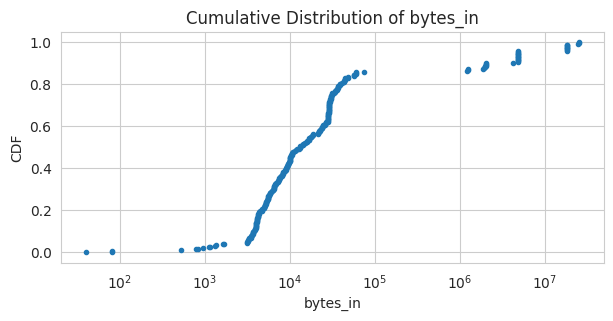

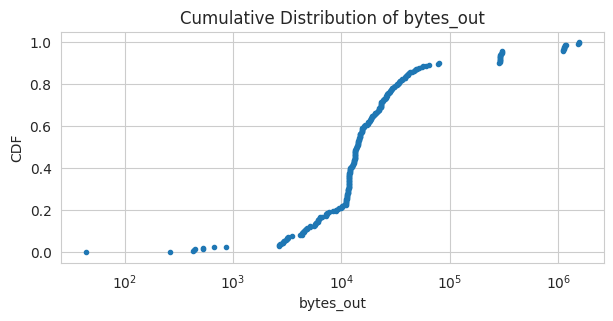

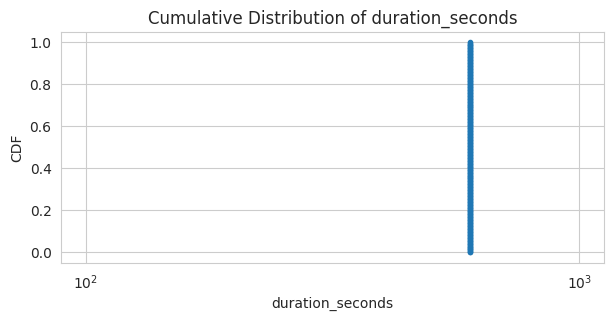

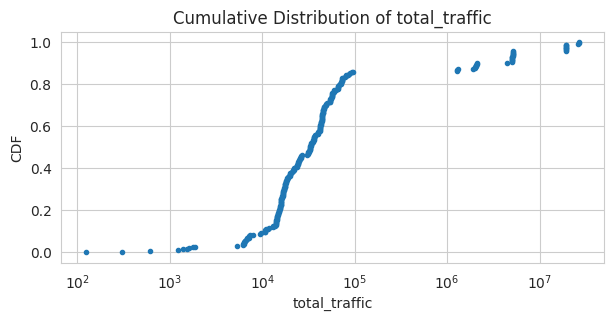

In [ ]:
import numpy as np

for col in features:
    sorted_vals = np.sort(cyber[col])
    cdf = np.arange(len(sorted_vals)) / float(len(sorted_vals))

    plt.figure(figsize=(7, 3))
    plt.plot(sorted_vals, cdf, marker='.', linestyle='none')
    plt.xscale('log')
    plt.title(f'Cumulative Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('CDF')
    plt.grid(True)
    plt.show()


🧠 Insights:

Helps decide thresholds for detection (e.g., "90% of traffic has less than X bytes").

## **4. Feature Engineering**

In [ ]:
# Feature engineering: Calculate duration of connection
cyber['duration_seconds'] = (cyber['end_time'] - cyber['creation_time']).dt.total_seconds()

# Preparing column transformations
# StandardScaler for numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cyber[['bytes_in', 'bytes_out', 'duration_seconds']])

In [ ]:
# OneHotEncoder for categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(cyber[['src_ip_country_code']])

# Combining transformed features back into the DataFrame
scaled_columns = ['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds']
encoded_columns = encoder.get_feature_names_out(['src_ip_country_code'])

In [ ]:
# Convert numpy arrays back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaled_columns, index=cyber.index)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=cyber.index)

# Concatenate all the data back together
transformed_df = pd.concat([cyber, scaled_df, encoded_df], axis=1)
# Displaying the transformed data
transformed_df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,...,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,...,-0.288219,-0.281223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,...,-0.282108,-0.260804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,...,-0.282689,-0.279344,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,...,-0.282197,-0.276161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,-0.287996,-0.277678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## **5. Modeling: Anomaly Detection**

In [ ]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
# Use the correct DataFrame 'scaled_df' containing the scaled features
cyber['anomaly_score'] = iso_forest.fit_predict(cyber[['bytes_in', 'bytes_out', 'duration_seconds']])

# Step 5: Add anomaly labels back to original dataframe
cyber['is_anomaly'] = -1  # default
cyber.loc[cyber.index, 'is_anomaly'] = cyber['anomaly_score']
cyber['is_anomaly'] = cyber['is_anomaly'].map({1: 0, -1: 1})  # 1 = anomaly, 0 = normal

# Check results
print("Anomalies detected:", cyber['is_anomaly'].sum())

Anomalies detected: 9


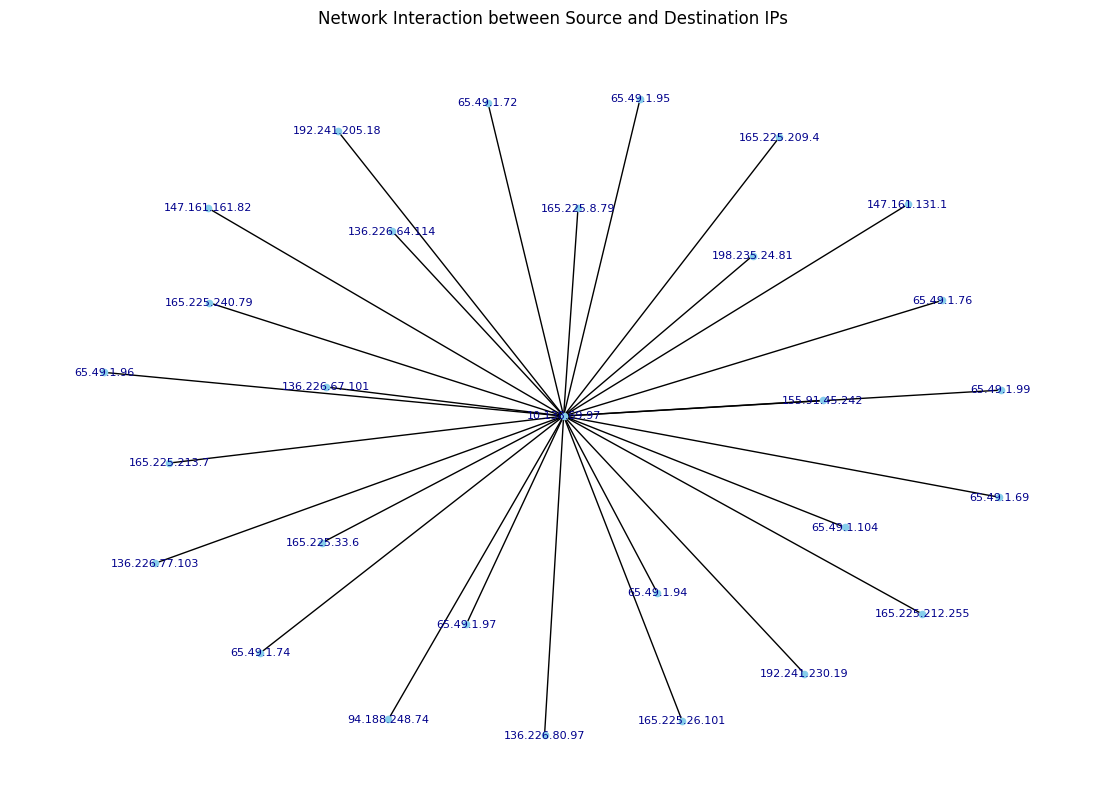

In [ ]:
# Create a graph
G = nx.Graph()
# Add edges from source IP to destination IP
for idx, row in data.iterrows():
  G.add_edge(row['src_ip'], row['dst_ip'])
# Draw the network graph
plt.figure(figsize=(14, 10))
nx.draw_networkx(G, with_labels=True, node_size=20,
font_size=8, node_color='skyblue', font_color='darkblue')
plt.title('Network Interaction between Source and Destination IPs')
plt.axis('off') # Turn off the axis
# Show the plot
plt.show()

Random Forest Classifier

In [ ]:
#First, encode this column into binary labels
cyber['is_suspicious'] =(cyber['detection_types'] == 'waf_rule').astype(int)
# Features and Labels
X = cyber[['bytes_in', 'bytes_out','duration_seconds']] # Numeric features
y = cyber['is_suspicious'] # Binary labels

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.3, random_state=42)
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100,
random_state=42)
# Train the model
rf_classifier.fit(X_train, y_train)
# Predict on the test set
y_pred = rf_classifier.predict(X_test)

In [ ]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)
print("Model Accuracy: ",accuracy)

Model Accuracy:  1.0


In [ ]:
print("Classification Report: ",classification)

Classification Report:                precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



Neural Network

In [ ]:
data['is_suspicious'] = (data['detection_types'] ==
'waf_rule').astype(int)
# Features and labels
X = data[['bytes_in', 'bytes_out']].values # Using only numeric features
y = data['is_suspicious'].values
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.3, random_state=42)
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Neural network model
model = Sequential([
Dense(8, activation='relu',
input_shape=(X_train_scaled.shape[1],)),
Dense(16, activation='relu'),
Dense(1, activation='sigmoid')
])
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy',
metrics=['accuracy'])
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10,
batch_size=8, verbose=1)
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8723 - loss: 0.6783
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.6110
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.5523
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.4802
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.4060
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.3155  
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2378 
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.1627 
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1022 
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0710 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0552 
Test Accuracy: 100.00%


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.4941 - loss: 0.6986 - val_accuracy: 1.0000 - val_loss: 0.6056
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9793 - loss: 0.6105 - val_accuracy: 1.0000 - val_loss: 0.5144
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.5363 - val_accuracy: 1.0000 - val_loss: 0.4364
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.4485 - val_accuracy: 1.0000 - val_loss: 0.3599
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.3668 - val_accuracy: 1.0000 - val_loss: 0.2827
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.3020 - val_accuracy: 1.0000 - val_loss: 0.2091
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.2176 - val_accuracy: 1.0000 - val_loss: 0.1448
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.1516 - val_accuracy: 1.0000 - val_loss: 0.0950


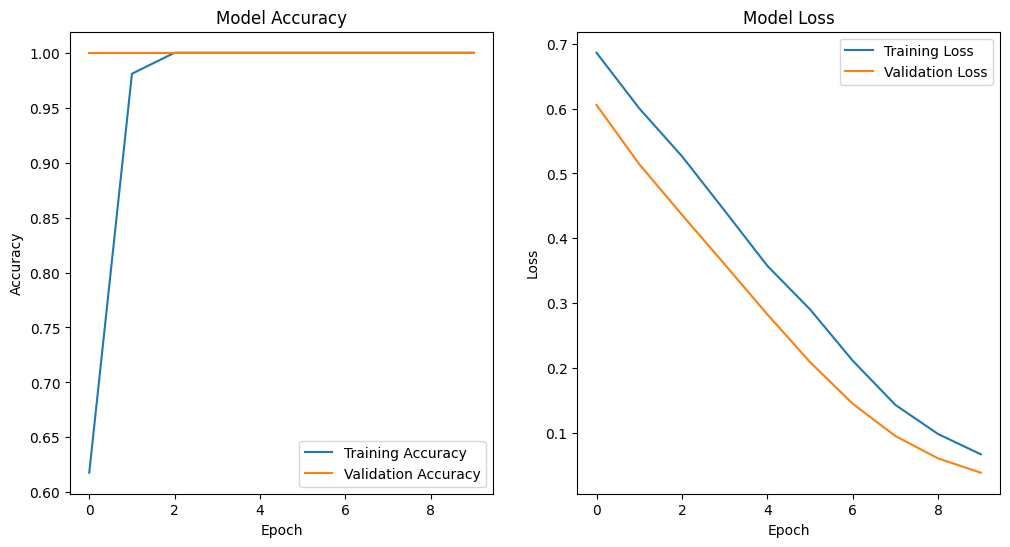

In [ ]:
# Neural network model
model = Sequential([
Dense(128, activation='relu',
input_shape=(X_train_scaled.shape[1],)),
Dropout(0.5),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(1, activation='sigmoid')
])
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy',
metrics=['accuracy'])
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10,
batch_size=32, verbose=1, validation_split=0.2)
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
# Plotting the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.6052 - loss: 0.6828 - val_accuracy: 1.0000 - val_loss: 0.6333
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9663 - loss: 0.6267 - val_accuracy: 1.0000 - val_loss: 0.5682
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.5683 - val_accuracy: 1.0000 - val_loss: 0.5096
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.5262 - val_accuracy: 1.0000 - val_loss: 0.4542
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.4639 - val_accuracy: 1.0000 - val_loss: 0.4017
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.4166 - val_accuracy: 1.0000 - val_loss: 0.3501
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.3598 - val_accuracy: 1.0000 - val_loss: 0.2993
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 0.3127 - val_accuracy: 1.0000 - val_loss: 0.2497

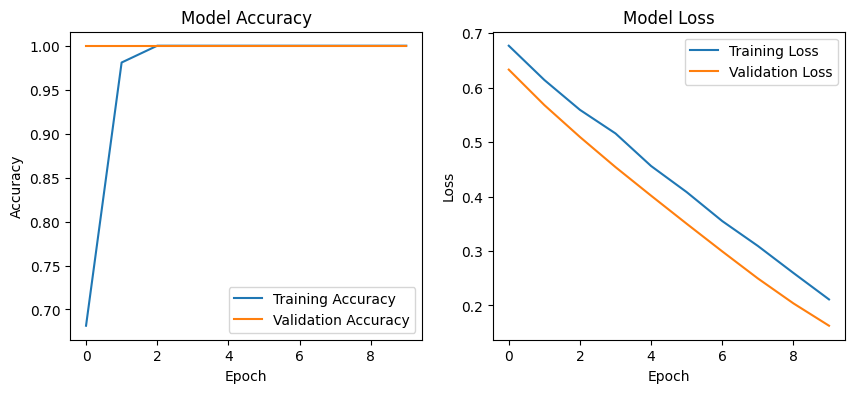

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1,
X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1,
X_test.shape[-1])).reshape(X_test.shape)
# Adjusting the network to accommodate the input size
model = Sequential([
Conv1D(32, kernel_size=1, activation='relu',
input_shape=(X_train_scaled.shape[1], 1)),
Flatten(),
Dense(64, activation='relu'),
Dropout(0.5),
Dense(1, activation='sigmoid')
])
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy',
metrics=['accuracy'])
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10,
batch_size=32, verbose=1, validation_split=0.2)
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
# Plotting the training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()